In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from itertools import product
from datetime import datetime
from dateutil.parser import parse
import os
import warnings
# warnings.filterwarnings('ignore')
# plt.style.use('seaborn-poster')
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import pickle
from scipy.stats import norm
from distfit import distfit

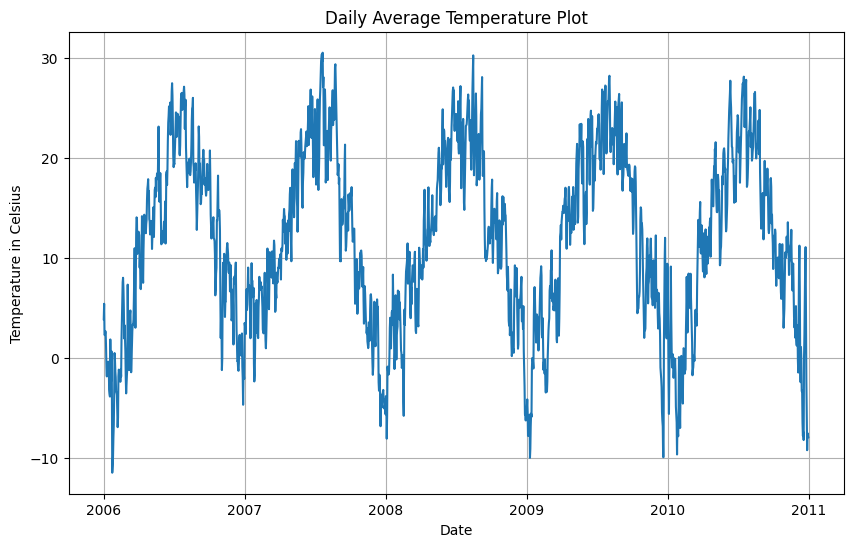

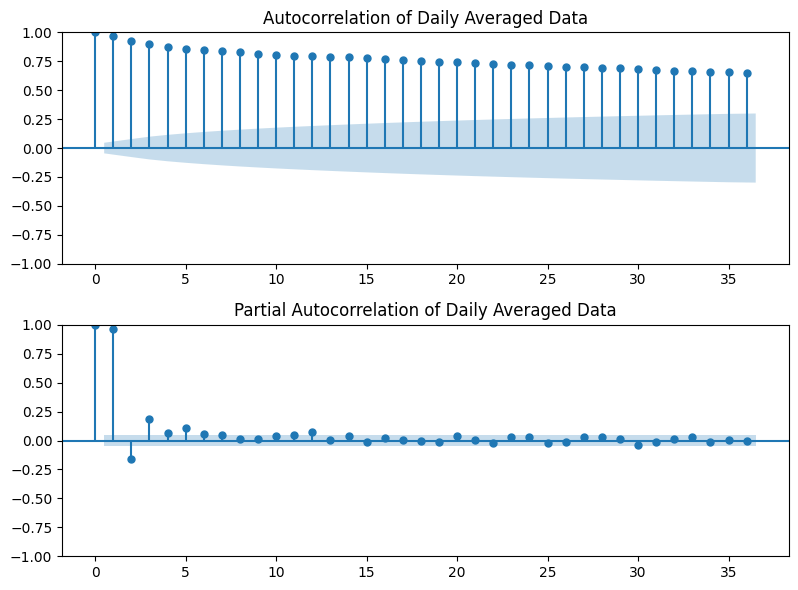

In [2]:
df = pd.read_csv('weatherHistory.csv')
#df.head()

# Zmiana nazw kolumn
df = df.rename(columns={'Temperature (C)': 'Temperature'})
df = df.rename(columns={'Formatted Date': 'Date'})


# Konwertowanie daty
df['Date'] = df['Date'].astype(str)
df['Date'] = df['Date'].apply(lambda x: x.split('+')[0].strip())
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S.%f')

# Sortowanie
df = df.sort_values(by='Date')

# Wybór danych z lat 2006/09
df = df[(df['Date'].dt.year >= 2006) & (df['Date'].dt.year <= 2010)]

# Dane co 6h
#df = df.iloc[::6]
df_reduced = df[['Date', 'Temperature']]
df = df_reduced.resample('D', on='Date').mean()

# Podstawowy wykres temperatury
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Temperature'])
plt.title("Daily Average Temperature Plot")
plt.xlabel('Date')
plt.ylabel('Temperature in Celsius')
plt.grid(True)
plt.show()

# Badanie autokorelacji danych
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

sm.graphics.tsa.plot_acf(df['Temperature'], lags=36, ax=ax1)
ax1.set_title("Autocorrelation of Daily Averaged Data")

sm.graphics.tsa.plot_pacf(df['Temperature'], lags=36, ax=ax2)
ax2.set_title("Partial Autocorrelation of Daily Averaged Data")

plt.tight_layout()
plt.show()

Dickey–Fuller test: p=0.078862


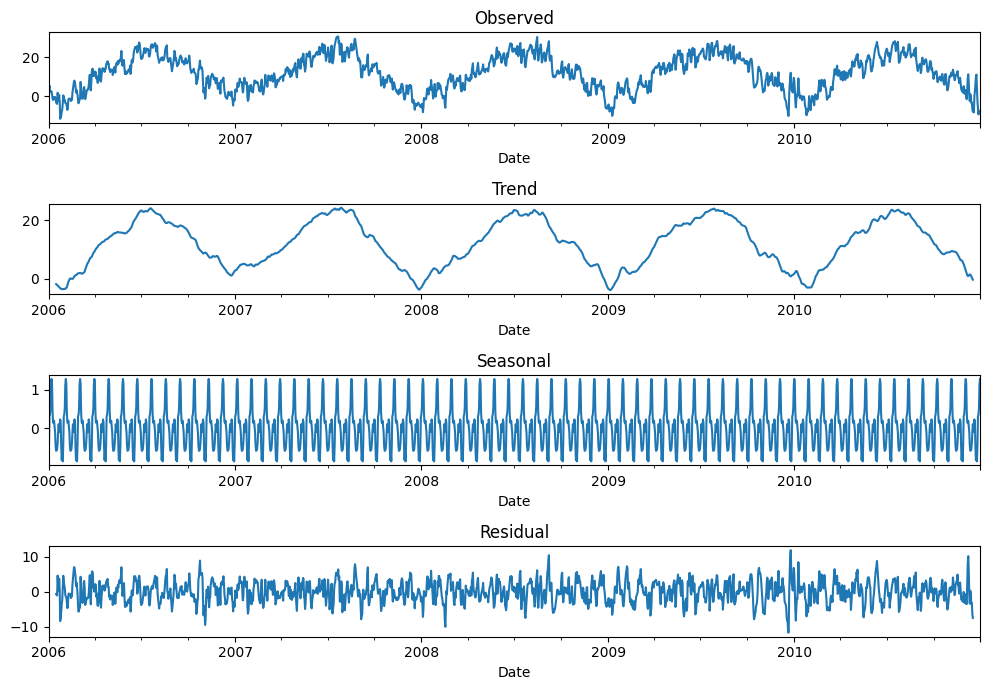

In [3]:
# Indeksowanie po dacie do sm.tsa
# df_copy = df[['Date', 'Temperature_K']].copy()
# df_copy = df_copy.set_index('Date')
df_copy = df[['Temperature']].copy()

# Dekompozycja Walda + test na stacjonarność szeregu
# plt.figure(figsize=[8,6])
# sm.tsa.seasonal_decompose(df_copy.Temperature_K, period=4*7).plot()
# plt.show()

print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_copy.Temperature)[1])

# Drugi sposób (wieksze wykresy)
decomposition = sm.tsa.seasonal_decompose(df_copy, model='additive', period=4*7) #1460//6
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 7))
decomposition.observed.plot(ax=ax1)
ax1.set_title('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_title('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_title('Residual')
plt.tight_layout()
plt.show()

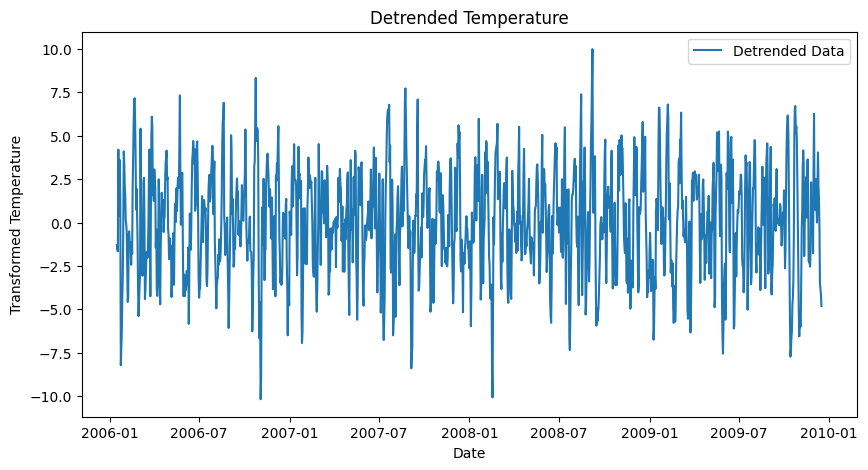

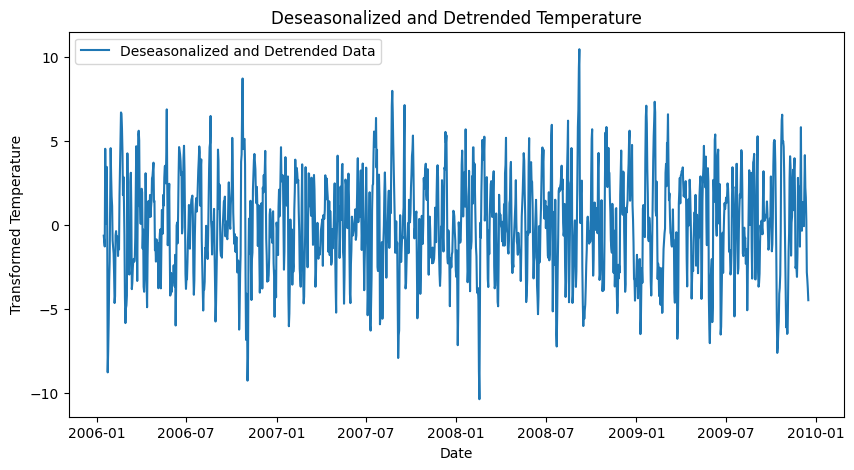

Dickey–Fuller test: p=0.000000


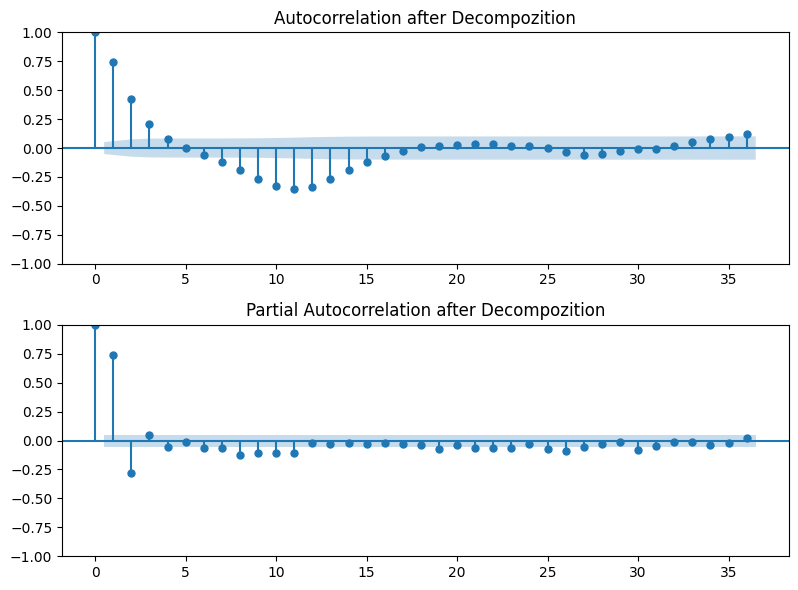

In [4]:
# Podział na train i test
train_size = int(len(df_copy) * 0.8)
train, test = df_copy[:train_size], df_copy[train_size:]
# train = df_copy[df_copy.index.year < 2010]
# test = df_copy[df_copy.index.year == 2010]

# Transformacja Boxa-Coxa
# train_transformed, lmbda = stats.boxcox(train.Temperature_K)
# print(f"Lambda z transformacji BoxaCoxa: {lmbda}")

train_transformed = train.Temperature

# Dekompozycja danych na trend, sezonowość i resztę
decomposition = sm.tsa.seasonal_decompose(train_transformed, model='additive', period=28)

# Usunięcie trendu i sezonowości
detrended = train_transformed - decomposition.trend
deseasonalized = detrended - decomposition.seasonal

# Wykres po usunięciu trendu
plt.figure(figsize=(10, 5))
plt.plot(train.index, detrended, label='Detrended Data')
plt.xlabel("Date")
plt.ylabel("Transformed Temperature")
plt.title("Detrended Temperature")
plt.legend()
plt.show()

# Wykres detrendowanych i deseasonalizowanych danych
plt.figure(figsize=(10, 5))
plt.plot(train.index, deseasonalized, label='Deseasonalized and Detrended Data')
plt.xlabel("Date")
plt.ylabel("Transformed Temperature")
plt.title("Deseasonalized and Detrended Temperature")
plt.legend()
plt.show()

# Usunięcie wartości NaN i stworzenie nowego DataFrame
deseasonalized_series = pd.Series(deseasonalized, index=train.index)
deseasonalized_series.dropna(inplace=True)
deseasonalized_df = pd.DataFrame({'Transformed_T': deseasonalized_series})

# Test stacjonarności po dekompozycji Walda
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(deseasonalized_df.Transformed_T)[1])


# Badanie autokorelacji danych
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
sm.graphics.tsa.plot_acf(deseasonalized_df.Transformed_T.values.squeeze(), lags=36, ax=ax1)
ax1.set_title("Autocorrelation after Decompozition")
sm.graphics.tsa.plot_pacf(deseasonalized_df.Transformed_T.values.squeeze(), lags=36, ax=ax2)
ax2.set_title("Partial Autocorrelation after Decompozition")
plt.tight_layout()
plt.show()

# Badanie autokorelacji danych po dekompozycji
# ax = plt.subplot(211)
# sm.graphics.tsa.plot_acf(deseasonalized_df.Transformed_T.values.squeeze(), lags=36, ax=ax)
# plt.title("Autokorelacja danych po dekompozycji")
# ax = plt.subplot(212)
# sm.graphics.tsa.plot_pacf(deseasonalized_df.Transformed_T.values.squeeze(), lags=36, ax=ax)
# plt.title("Częściowa autokorelacja danych po dekompozycji")
# plt.show()

In [5]:
# Dopasowywanie najlepszych parametrów p, q
def test_model(data):
    qs = range(0, 5)
    ps = range(0, 5)
    d = 0

    parameters = product(ps, qs)
    parameters_list = list(parameters)

    # Model Selection
    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')
    for param in parameters_list:
        try:
            model = ARIMA(data, order=(param[0], d, param[1])).fit()
        except ValueError:
            #print('wrong parameters:', param)
            continue
        aic = model.aic
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    return results, best_model

In [6]:
results, best_model = test_model(deseasonalized_df.Transformed_T)

# Best Model
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())
print(best_model.summary())

# Zapisywanie modelu
with open('best_model.pkl', 'wb') as pkl_file:
    pickle.dump(best_model, pkl_file)

# Wczytywanie modelu
with open('best_model.pkl', 'rb') as pkl_file:
    loaded_model = pickle.load(pkl_file)

   parameters          aic
17     (3, 2)  5783.738999
12     (2, 2)  5785.470458
19     (3, 4)  5786.079444
23     (4, 3)  5786.664989
18     (3, 3)  5787.658356
                               SARIMAX Results                                
Dep. Variable:          Transformed_T   No. Observations:                 1432
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -2884.869
Date:                Sun, 23 Jun 2024   AIC                           5783.739
Time:                        21:02:39   BIC                           5820.607
Sample:                    01-15-2006   HQIC                          5797.505
                         - 12-16-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0018      0.003      0.716     

In [7]:
# Transformacja danych test za pomocą lamby z train
#test_transformed = stats.boxcox(test.Temperature_K, lmbda=lmbda)
test_transformed = np.array(test.Temperature)

# Dekompozycja testowych
decomposition_test = sm.tsa.seasonal_decompose(test_transformed, model='additive', period=28)
detrended_test = test_transformed - decomposition_test.trend
deseasonalized_test = detrended_test - decomposition_test.seasonal
deseasonalized_test_series = pd.Series(deseasonalized_test, index=test.index)
deseasonalized_test_series.dropna(inplace=True)

# Predykcje
#predicted_values = loaded_model.forecast(steps=len(deseasonalized_test_series))
forecast_result = loaded_model.get_forecast(steps=len(deseasonalized_test_series))
predicted_values = forecast_result.predicted_mean
conf_int = forecast_result.conf_int(0.95)

# Dodanie trendu i sezonowości
predicted_values_recomposed = predicted_values + decomposition_test.trend[:len(predicted_values)] + decomposition_test.seasonal[:len(predicted_values)]
conf_int_recomposed = conf_int + decomposition_test.trend[:len(predicted_values)].reshape(-1, 1) + decomposition_test.seasonal[:len(predicted_values)].reshape(-1, 1)

# Cofnięcie transformacji
def invboxcox(y, lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))
# predicted_values_original_scale = invboxcox(predicted_values_recomposed, lmbda)
# conf_int_original_scale = invboxcox(conf_int_recomposed, lmbda)

predicted_values_original_scale = predicted_values_recomposed
conf_int_original_scale = conf_int_recomposed

# Obliczenie MSE
mse = np.mean((test.Temperature[14:len(predicted_values_original_scale)] - predicted_values_original_scale[14:])**2)
print(f"MSE: {mse:.2f}")

# Obliczenie MAE
mae = np.mean(np.abs(test.Temperature[14:len(predicted_values_original_scale)] - predicted_values_original_scale[14:]))
print(f"MAE: {mae:.2f}")

MSE: 18.13
MAE: 3.48


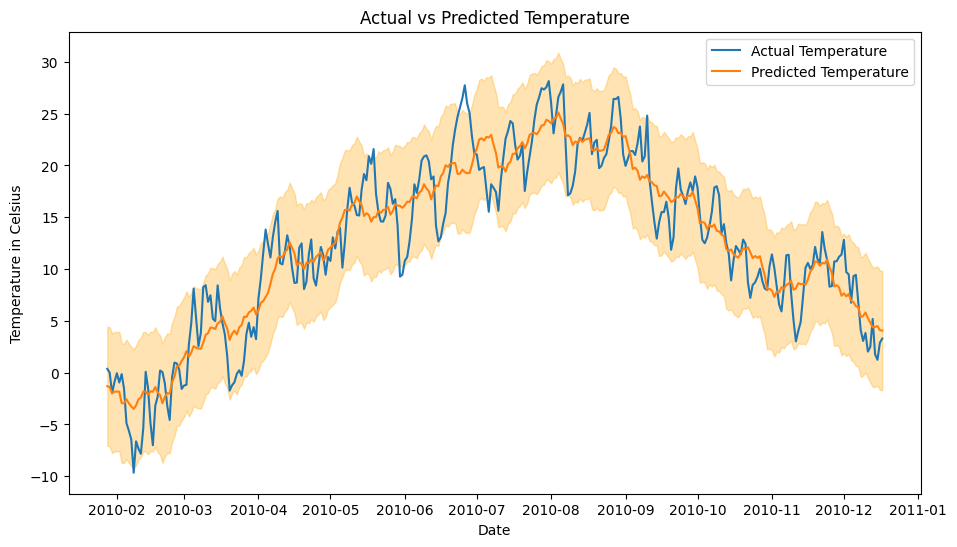

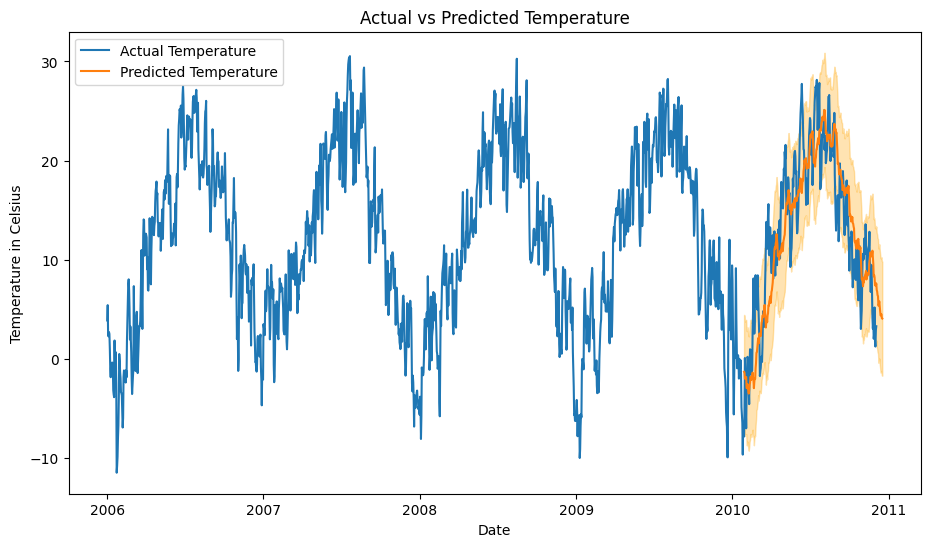

In [8]:
# Dla stopni
test['Temperature_C'] = test['Temperature']
predicted_values_original_scale_C = predicted_values_original_scale
conf_int_original_scale_C = conf_int_original_scale

plt.figure(figsize=(11, 6))
plt.plot(deseasonalized_test_series.index[14:], test.Temperature_C[14:len(predicted_values_original_scale)], label='Actual Temperature')
plt.plot(deseasonalized_test_series.index[14:], predicted_values_original_scale_C[14:], label='Predicted Temperature')
plt.fill_between(deseasonalized_test_series.index[14:], conf_int_original_scale_C['lower Transformed_T'][14:], conf_int_original_scale_C['upper Transformed_T'][14:], color='orange', alpha=0.3)
plt.title("Actual vs Predicted Temperature")
plt.xlabel('Date')
plt.ylabel('Temperature in Celsius')
plt.legend()
plt.show()

plt.figure(figsize=(11, 6))
plt.plot(df.index[:-28], df.Temperature[:-28], label='Actual Temperature')
plt.plot(deseasonalized_test_series.index, predicted_values_original_scale_C, label='Predicted Temperature')
plt.fill_between(deseasonalized_test_series.index[14:], conf_int_original_scale_C['lower Transformed_T'][14:], conf_int_original_scale_C['upper Transformed_T'][14:], color='orange', alpha=0.3)
plt.xlabel("Date")
plt.ylabel("Temperature in Celsius")
plt.title("Actual vs Predicted Temperature")
plt.legend()
plt.show()

0.006490511641903195


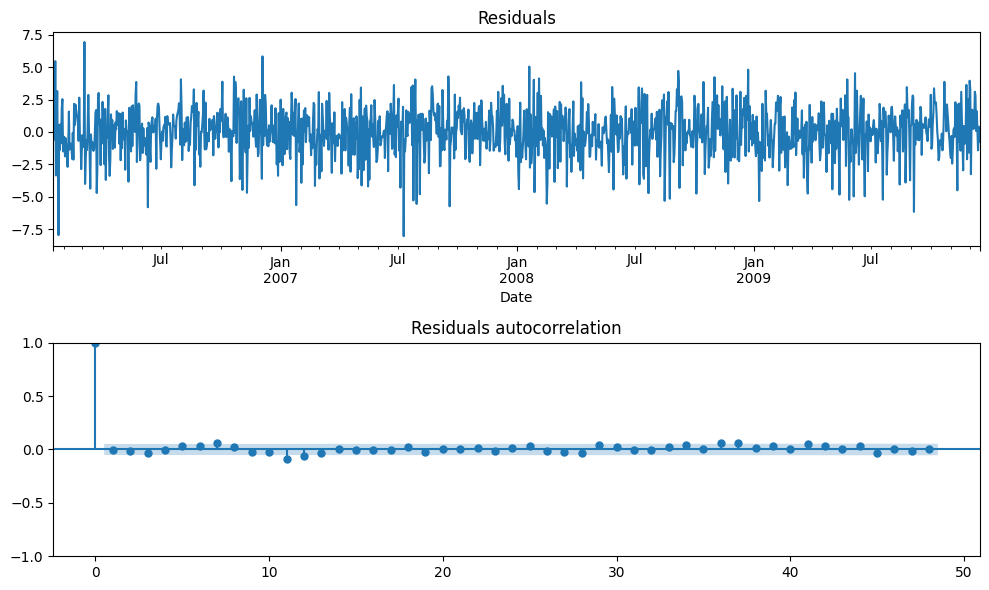

In [9]:
# Sprawdzanie założeń dotyczacych residuuów modelu
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.title('Residuals')
loaded_model.resid.plot()

mu = np.mean(loaded_model.resid)
print(mu)

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(loaded_model.resid.values.squeeze(), lags=48, ax=ax, title='Residuals autocorrelation')
plt.tight_layout()
plt.show()

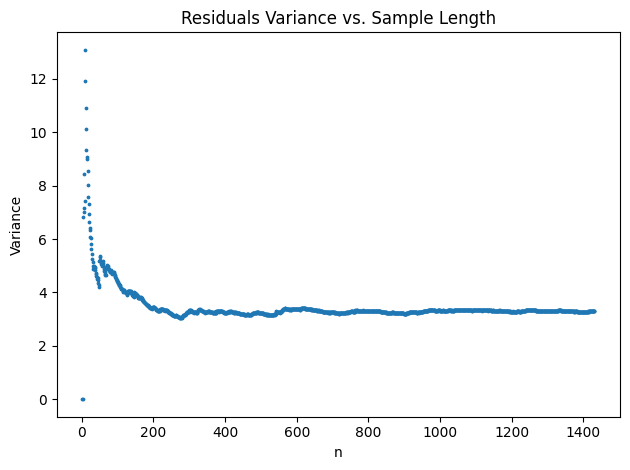

In [10]:
# Sprawdzenie stałości wariancji
e = loaded_model.resid
t232 = [i for i in range(2, len(e))]
war = [np.var(e[:i]) for i in range(2, len(e))]
plt.title("Residuals Variance vs. Sample Length")
plt.ylabel("Variance")
plt.xlabel("n")
plt.scatter(t232, war, s=3)

plt.tight_layout()
plt.show()

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0110533] [loc=0.006 scale=1.815]
[distfit] >[expon     ] [0.0 sec] [RSS: 0.447775] [loc=-8.045 scale=8.052]
[distfit] >[pareto    ] [0.00 sec] [RSS: 0.447775] [loc=-1073741832.045 scale=1073741824.000]
[distfit] >[dweibull  ] [0.02 sec] [RSS: 0.00547675] [loc=0.007 scale=1.459]
[distfit] >[t         ] [0.08 sec] [RSS: 0.00410545] [loc=0.055 scale=1.576]
[distfit] >[genextreme] [0.09 sec] [RSS: 0.0242379] [loc=-0.683 scale=1.903]
[distfit] >[gamma     ] [0.06 sec] [RSS: 0.0144099] [loc=-32.687 scale=0.103]
[distfit] >[lognorm   ] [0.09 sec] [RSS: 0.0107839] [loc=-255.943 scale=255.953]
[distfit] >[beta      ] [0.11 sec] [RSS: 0.00974281] [loc=-501.745 scale=517.131]
[distfit] >[uniform   ] [0.0 sec] [RSS: 0.336079] [loc=-8.045 scale=14.991]
[distfit] >[loggamma  ] [0.01 sec] [RSS: 0.00939447] [loc=-17.649 scale=6.727]
[distfit] >Compute confidence interval [parametric]


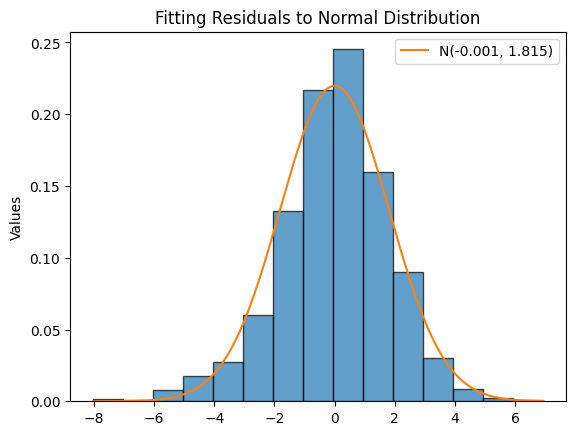

In [11]:
# Dopasowanie residuuów do rozkładu normalnego
dist = distfit()
model = dist.fit_transform(best_model.resid)
#dist.plot()

plt.hist(loaded_model.resid, bins=15, alpha=0.7, edgecolor='k', density=True)
t = np.linspace(min(loaded_model.resid), max(loaded_model.resid), 1000)
plt.plot(t, norm.pdf(t, loc=-0.001, scale=1.815), label="N(-0.001, 1.815)")

plt.ylabel("Values")
plt.title("Fitting Residuals to Normal Distribution")
plt.legend()
plt.show()